In [ ]:
# 폰트 다운로드 [런타임 재시작 필수]
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (45.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

# 비대칭 데이터 문제

데이터 클래스 비율이 너무 차이가 나면(highly-imbalanced data) 단순히 우세한 클래스를 택하는 모형의 정확도가 높아지므로 모형의 성능판별이 어려워진다. 즉, 정확도(accuracy)가 높아도 데이터 갯수가 적은 클래스의 재현율(recall-rate)이 급격히 작아지는 현상이 발생할 수 있다.

이렇게 각 클래스에 속한 데이터의 갯수의 차이에 의해 발생하는 문제들을 비대칭 데이터 문제(imbalanced data problem)이라고 한다.

In [ ]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


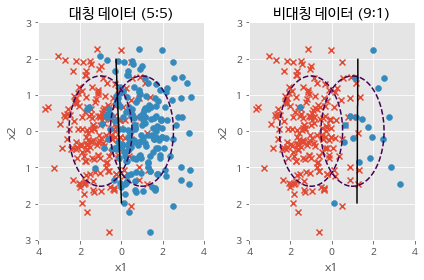

In [ ]:
def classification_result(n0, n1, title=""):
    rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
    rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
    X0 = rv1.rvs(n0, random_state=0)
    X1 = rv2.rvs(n1, random_state=0)
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0), np.ones(n1)])

    x1min = -4; x1max = 4
    x2min = -2; x2max = 2
    xx1 = np.linspace(x1min, x1max, 1000)
    xx2 = np.linspace(x2min, x2max, 1000)
    X1, X2 = np.meshgrid(xx1, xx2)

    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")

    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    
    return model, X, y, y_pred
    
plt.subplot(121)
model1, X1, y1, y_pred1 = classification_result(200, 200, "대칭 데이터 (5:5)")
plt.subplot(122)
model2, X2, y2, y_pred2 = classification_result(200, 20, "비대칭 데이터 (9:1)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y1, y_pred1))
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       200
         1.0       0.84      0.86      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       200
         1.0       0.75      0.60      0.67        20

    accuracy                           0.95       220
   macro avg       0.86      0.79      0.82       220
weighted avg       0.94      0.95      0.94       220



<해석> 
- 0이라고 예측한 것 중에 실제 0인게 96% 
- 1이라고 예측한 것 중에 실제 1인게 75% 

- 실제 0인 것중에 0이라고 맞춘 것은 98%
- 실제 1인 것중에 1이라고 맞춘 것은 60% 

- 실제 0인 건 200개 
- 실제 1인 건 20개

- Acc는 95% 



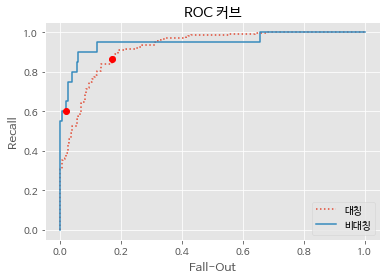

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix

fpr1, tpr1, thresholds1 = roc_curve(y1, model1.decision_function(X1))
fpr2, tpr2, thresholds2 = roc_curve(y2, model2.decision_function(X2))

c1 = confusion_matrix(y1, y_pred1, labels=[1, 0])
c2 = confusion_matrix(y2, y_pred2, labels=[1, 0])
r1 = c1[0, 0] / (c1[0, 0] + c1[0, 1])
r2 = c2[0, 0] / (c2[0, 0] + c2[0, 1])
f1 = c1[1, 0] / (c1[1, 0] + c1[1, 1])
f2 = c2[1, 0] / (c2[1, 0] + c2[1, 1])

plt.plot(fpr1, tpr1, ':', label="대칭")
plt.plot(fpr2, tpr2, '-', label="비대칭")
plt.plot([f1], [r1], 'ro')
plt.plot([f2], [r2], 'ro')
plt.legend()
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('ROC 커브')
plt.show()

## 해결 방법

비대칭 데이터는 다수 클래스 데이터에서 일부만 사용하는 **언더 샘플링**이나 소수 클래스 데이터를 증가시키는 **오버 샘플링**을 사용하여 데이터 비율을 맞추면 정밀도(precision)가 향상된다.

* 오버샘플링(Over-Sampling)
* 언더샘플링(Under-Sampling)
* 복합샘플링(Combining Over-and Under-Sampling)

## imbalanced-learn 패키지

imbalanced data 문제를 해결하기 위한 다양한 샘플링 방법을 구현한 파이썬 패키지


```
pip install -U imbalanced-learn
```

## 언더 샘플링

* `RandomUnderSampler`: random under-sampling method
* `TomekLinks`: Tomek’s link method
* `CondensedNearestNeighbour`: condensed nearest neighbour method
* `OneSidedSelection`: under-sampling based on one-sided selection method
* `EditedNearestNeighbours`: edited nearest neighbour method
* `NeighbourhoodCleaningRule`: neighbourhood cleaning rule

In [ ]:
from imblearn.under_sampling import *

n0 = 200; n1 = 20
rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
X0 = rv1.rvs(n0, random_state=0)
X1 = rv2.rvs(n1, random_state=0)
X_imb = np.vstack([X0, X1])
y_imb = np.hstack([np.zeros(n0), np.ones(n1)])

x1min = -4; x1max = 4
x2min = -2; x2max = 2
xx1 = np.linspace(x1min, x1max, 1000)
xx2 = np.linspace(x2min, x2max, 1000)
X1, X2 = np.meshgrid(xx1, xx2)

def classification_result2(X, y, title=""):
    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    return model

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Ramdom Under-Sampler

* 무작위로 데이터를 없애는 단순 샘플링

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


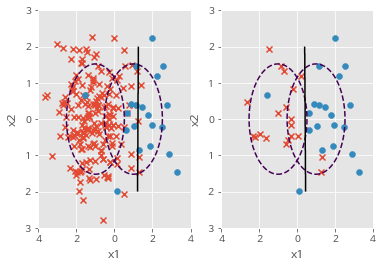

In [ ]:
X_samp, y_samp = RandomUnderSampler(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       200
         1.0       0.51      0.90      0.65        20

    accuracy                           0.91       220
   macro avg       0.75      0.91      0.80       220
weighted avg       0.95      0.91      0.92       220



## Tomek’s link method

토멕링크(Tomek’s link)란 서로 다른 클래스에 속하는 한 쌍의 데이터 $(x_{+}, x_{-})$로 서로에게 더 가까운 다른 데이터가 존재하지 않는 것이다. 즉 클래스가 다른 두 데이터가 아주 가까이 붙어있으면 토멕링크가 된다. 토멕링크 방법은 이러한 토멕링크를 찾은 다음 그 중에서 다수 클래스에 속하는 데이터를 제외하는  방법으로 경계선을 다수 클래스쪽으로 밀어붙이는 효과가 있다.

<img src="https://datascienceschool.net/upfiles/40e445c6271b438194813ebf54431d17.png" width="100%"/>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


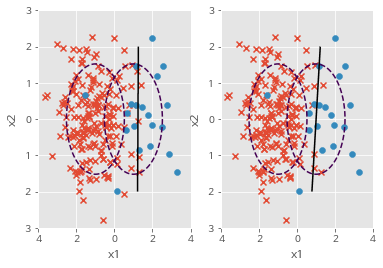

In [ ]:
X_samp, y_samp = TomekLinks(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.70      0.70      0.70        20

    accuracy                           0.95       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.95      0.95      0.95       220



## Condensed Nearest Neighbour

CNN(Condensed Nearest Neighbour) 방법은 1-NN 모형으로 분류되지 않는 데이터만 남기는 방법이다. 선텍된 데이터 집합을 $S$라고 하자.

1. 소수 클래스 데이터를 모두 $S$에 포함시킨다.
2. 다수 데이터 중에서 하나를 골라서 가장 가까운 데이터가 다수 클래스이면 포함시키지 않고 아니면 $S$에 포함시킨다.
3. 더이상 선택되는 데이터가 없을 때까지 2를 반복한다.

이 방법을 사용하면 기존에 선택된 데이터와 가까이 있으면서 같은 클래스인 데이터는 선택되지 않기 때문에 다수 데이터의 경우 선택되는 비율이 적어진다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

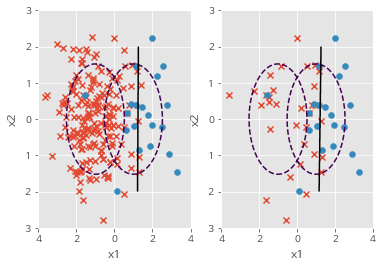

In [ ]:
X_samp, y_samp = CondensedNearestNeighbour(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       200
         1.0       0.75      0.60      0.67        20

    accuracy                           0.95       220
   macro avg       0.86      0.79      0.82       220
weighted avg       0.94      0.95      0.94       220



## One Sided Selection

One Sided Selection은 토맥링크 방법과 Condensed Nearest Neighbour 방법을 섞은 것이다. 토맥링크 중 다수 클래스를 제외하고 나머지 데이터 중에서도 서로 붙어있는 다수 클래스 데이터는 1-NN 방법으로 제외한다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183

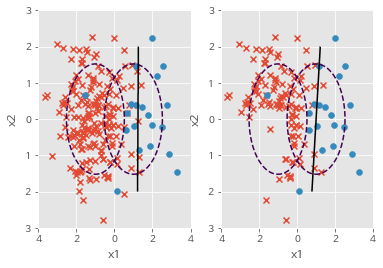

In [ ]:
X_samp, y_samp = OneSidedSelection(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.70      0.70      0.70        20

    accuracy                           0.95       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.95      0.95      0.95       220



## Edited Nearest Neighbours

ENN(Edited Nearest Neighbours) 방법은 다수 클래스 데이터 중 가장 가까운 k(`n_neighbors`)개의 데이터가 모두(`kind_sel="all"`) 또는 다수(`kind_sel="mode"`) 다수 클래스가 아니면 삭제하는 방법이다. 소수 클래스 주변의 다수 클래스 데이터는 사라진다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


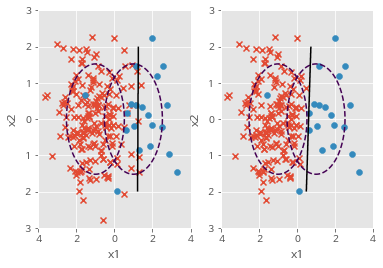

In [ ]:
X_samp, y_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       200
         1.0       0.58      0.90      0.71        20

    accuracy                           0.93       220
   macro avg       0.79      0.92      0.83       220
weighted avg       0.95      0.93      0.94       220



## Neighbourhood Cleaning Rule

Neighbourhood Cleaning Rule 방법은 CNN(Condensed Nearest Neighbour) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것이다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

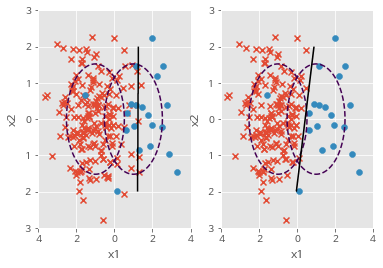

In [ ]:
X_samp, y_samp = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       200
         1.0       0.56      0.95      0.70        20

    accuracy                           0.93       220
   macro avg       0.78      0.94      0.83       220
weighted avg       0.96      0.93      0.94       220



## 오버 샘플링

* `RandomOverSampler`: random sampler
* `ADASYN`: Adaptive Synthetic Sampling Approach for Imbalanced Learning
* `SMOTE`: Synthetic Minority Over-sampling Technique

In [ ]:
from imblearn.over_sampling import *

## RandomOverSampler

Random Over Sampling은 소수 클래스의 데이터를 반복해서 넣는 것(replacement)이다. 가중치를 증가시키는 것과 비슷하다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


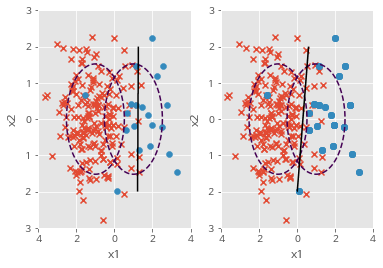

In [ ]:
X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.51      0.95      0.67        20

    accuracy                           0.91       220
   macro avg       0.75      0.93      0.81       220
weighted avg       0.95      0.91      0.92       220



## ADASYN

ADASYN(Adaptive Synthetic Sampling) 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법이다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


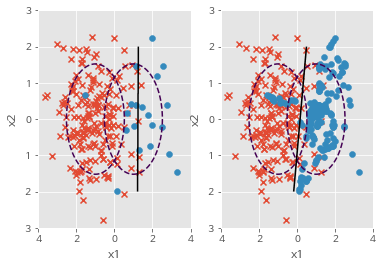

In [ ]:
X_samp, y_samp = ADASYN(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       200
         1.0       0.47      0.95      0.63        20

    accuracy                           0.90       220
   macro avg       0.73      0.92      0.79       220
weighted avg       0.95      0.90      0.91       220



## SMOTE

SMOTE(Synthetic Minority Over-sampling Technique) 방법도 ADASYN 방법처럼 데이터를 생성하지만 생성된 데이터를 무조건 소수 클래스라고 하지 않고 분류 모형에 따라 분류한다.

<img src="https://datascienceschool.net/upfiles/e072f6e270884b2887051f2c10f433e7.png" width="100%"/>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


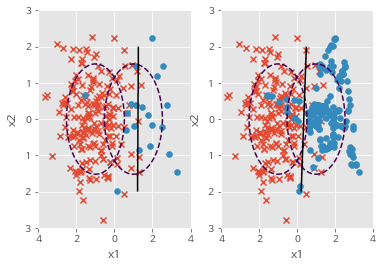

In [ ]:
X_samp, y_samp = SMOTE(random_state=4).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.50      0.90      0.64        20

    accuracy                           0.91       220
   macro avg       0.74      0.91      0.80       220
weighted avg       0.94      0.91      0.92       220



## 복합 샘플링

* `SMOTEENN`: SMOTE + ENN
* `SMOTETomek`: SMOTE + Tomek

In [ ]:
from imblearn.combine import *

## SMOTE+ENN

SMOTE+ENN 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것이다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

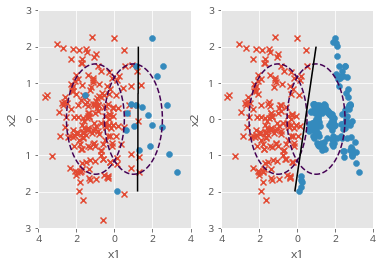

In [ ]:
X_samp, y_samp = SMOTEENN(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       200
         1.0       0.54      0.95      0.69        20

    accuracy                           0.92       220
   macro avg       0.77      0.94      0.82       220
weighted avg       0.95      0.92      0.93       220



## SMOTE+Tomek

SMOTE+Tomek 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 토멕링크 방법을 섞은 것이다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


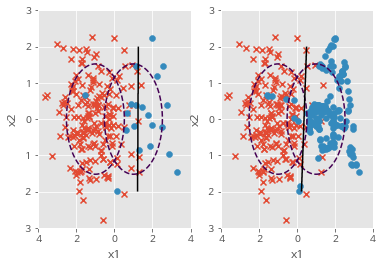

In [ ]:
X_samp, y_samp = SMOTETomek(random_state=4).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [ ]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       200
         1.0       0.51      0.90      0.65        20

    accuracy                           0.91       220
   macro avg       0.75      0.91      0.80       220
weighted avg       0.95      0.91      0.92       220

